In [1]:
import os
import zarr
import tifffile
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import warnings

warnings.filterwarnings('ignore')

base_dir = '/n/scratch3/users/z/ziz531/spot_detection_and_analysis/SpotDetection'
im_dir = os.path.join(base_dir, 'MX1.tif') 

def parse_array_string(arr_str):
    values = [int(val) for val in re.findall(r'\d+', arr_str)]
    return np.array(values)

def cube_max(im, x, y, z):
    cube = im[max(x-1, 0):x+2, max(y-1,0):y+2, max(z-1,0):z+2]
    return np.max( cube )

As the first step of the pipeline, we do spot detection on the downsampled 3D image of the MX1 channel taken from a melanoma in situ (check this) biopsy sample. The input image has voxel resolution of $0.28\mu m$ in all directions. The spot detection is done using a Laplacian of Gaussian filter using a range of kernel size to ensure we capture spots of different sizes. We then do repeated intensity gating and visual inspection of detected spots to choose the gating threshold. The resulting spots after applying the LoG filter and gating will be passed to the next step of the pipeline. 

The following python script includes the code for spot detection.

LoG-based spot detection using parameters from the above code will yield too many false positives. The next step is to select for the spots that are most likely due to specific detection of MX1 puncta using the corresponding antibody. The most straightforward method that we use here is to filter for spots whose center voxel intensity crosses some set threshold. To further remove false positive calls, we remove spots that are in manually labelled background as well as tissue skin regions of the image. These regions are defined by a 2D mask along x,y-direction extended through the entire z-stack.

In [2]:
bg_mask = np.load('./MX1_background_mask.npy')
skin_mask = np.load('./MX1_skin_mask.npy')
combined_mask = bg_mask | skin_mask


In [10]:
np.save('./combined_mask.npy', combined_mask)

Text(0.5, 1.0, 'Combined mask')

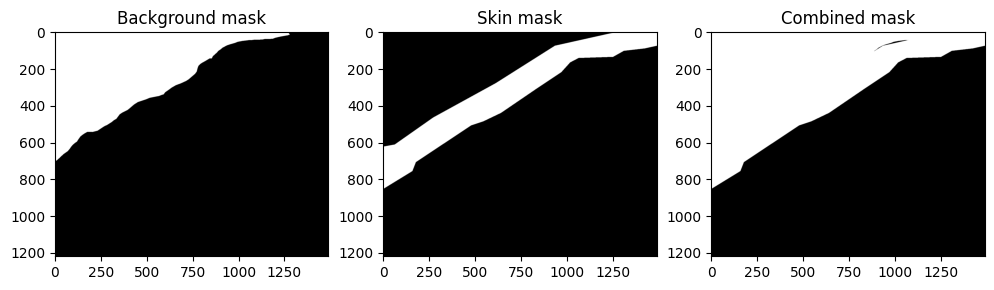

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.ravel()
axes[0].imshow(bg_mask, cmap='gray')
axes[1].imshow(skin_mask, cmap='gray')
axes[2].imshow(combined_mask, cmap='gray')
axes[0].set_title("Background mask")
axes[1].set_title("Skin mask")
axes[2].set_title("Combined mask")

In [4]:
im_raw = da.from_zarr(zarr.open(tifffile.imread(im_dir, aszarr=True))) # downscale for a speedup...
im = im_raw[::2, ::2, ::2].compute() # to numpy array

blobs = np.load('./blobs_1.00e-03.npy')
blobs_df = pd.read_csv('./blob_stats_1.00e-03')

In [5]:
from scipy.stats import median_abs_deviation

blobs_df['Location'] = blobs_df['Location'].apply(parse_array_string)
blobs_df['Center Intensity'] = blobs_df['Location'].apply(lambda arr: cube_max(im, *arr)) 
blobs_df['Within sample'] = blobs_df['Location'].apply(lambda loc: (not bg_mask[*loc[1:]]) and loc[0] in range(18, 89))
log_center_intensity = np.log10(blobs_df[blobs_df['Within sample']==True]['Center Intensity'])
log_center_intensity_median = np.median(log_center_intensity)
log_center_intensity_MAD = median_abs_deviation(log_center_intensity)

k = 10 * 1.428
proposed_intensity_threshold = 10**(log_center_intensity_median + k * log_center_intensity_MAD)

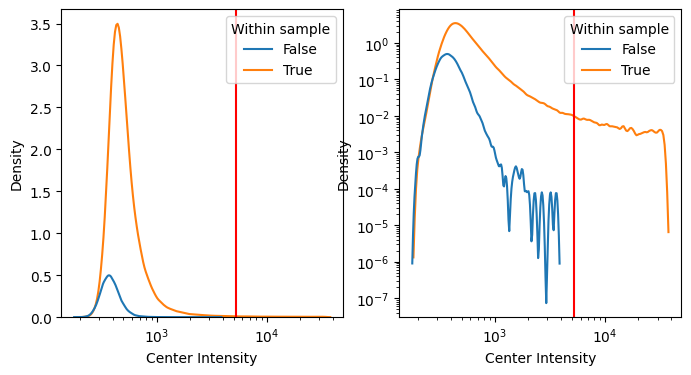

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(blobs_df, x='Center Intensity', hue='Within sample', log_scale=True, ax=axes[0])
sns.kdeplot(blobs_df, x='Center Intensity', hue='Within sample', log_scale=True, ax=axes[1])
axes[1].set_yscale('log')
axes[0].axvline(proposed_intensity_threshold, c='r')
axes[1].axvline(proposed_intensity_threshold, c='r')

In [7]:
blobs_df['Gating'] = (blobs_df['Center Intensity'] > proposed_intensity_threshold) &\
blobs_df['Location'].apply(lambda loc: (not combined_mask[*loc[1:]]))
blobs_subset = blobs[blobs_df['Gating']]
blobs_df = blobs_df[blobs_df['Gating']==True]
np.save('./MX1_puncta.npy', blobs_subset)
blobs_df.to_csv('./MX1_puncta_stats.csv')
blobs_subset.shape

(1714, 4)

Text(0.5, 1.0, 'z-projection of detected MX1 puncta in the sample')

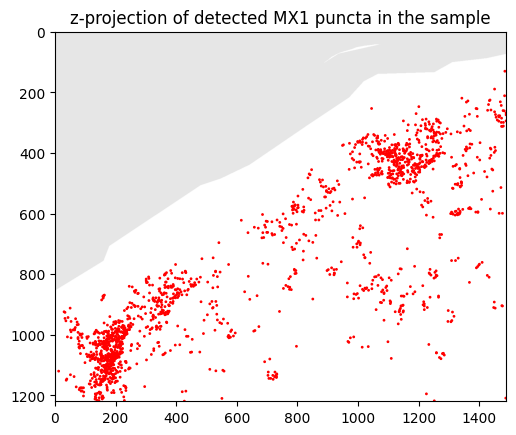

In [8]:
fig, ax = plt.subplots(1, 1)
ax.scatter([arr[2] for arr in blobs_df['Location']], 
           [arr[1] for arr in blobs_df['Location']], 
            s=blobs_df['Size'], c='red')
ax.invert_yaxis()
ax.imshow(~combined_mask, cmap='gray', alpha=0.1)
ax.set_title('z-projection of detected MX1 puncta in the sample')

Text(0.5, 1.0, 'KDE of detected MX1 puncta density along z-axis')

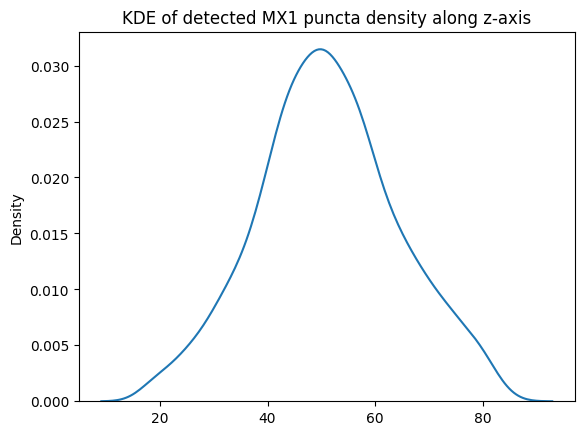

In [9]:
fig, ax = plt.subplots(1, 1)
sns.kdeplot([arr[0] for arr in blobs_df['Location']], ax=ax)
ax.set_title("KDE of detected MX1 puncta density along z-axis")
